# TW Hya Imaging Tutorial

This is a tutorial of synthesis imaging based on sparse modeling technique. Data for this tutorial is taken from [First Look at Imaging CASA Guide](https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) and can be downloaded from the link below:

https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

After you download the data, you should untar it to get MS. You may run the following cell to obtain the dataset.

In [1]:
%%bash
# download if necessary
[ -e sis14_twhya_calibrated_flagged.ms.tar ] || wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

# extract MS if it doesn't exist
[ -e sis14_twhya_calibrated_flagged.ms ] || tar xvf sis14_twhya_calibrated_flagged.ms.tar

Before you start this tutorial, you should install PRIISM and packages that PRIISM depends on (casatools, casatasks, etc.). Please see README.md on how to install PRIISM.

## Preparation

First, we make matplotlib figures to be displayed in the notebook.

In [2]:
%matplotlib inline

Next, we average visibility channels according to the procedure described in [the CASA Guide](https://casaguides.nrao.edu/index.php/First_Look_at_Imaging). This requires `casatasks` that should have been installed as a dependency of PRIISM. We use `twhya_smoothed.ms` in the subsequent steps.

In [3]:
import os
from casatasks import split, listobs

# overwrite output data if it exists
os.system('rm -rf twhya_smoothed.ms')
os.system('rm -f twhya_smoothed.listobs.txt')

split(vis='sis14_twhya_calibrated_flagged.ms', field='5', width='8', outputvis='twhya_smoothed.ms', datacolumn='data')

data_summary = listobs('twhya_smoothed.ms', verbose=True, listfile='twhya_smoothed.listobs.txt')

## Initialization

In PRIISM, we have two modules `priism` and `priism.alma`. The former is a set of core functionalities and primitive interface while the later is high-level interface specific to ALMA data. Here, we will use `priism.alma` because we are working with ALMA data. As a first step, we should create worker instance with solver option. The `mfista_nufft` solver is an implementation of MFISTA algorithm based on NUFFT. 

In [ ]:
import priism.alma
print(f'PRIISM version {priism.__version__}')
worker = priism.alma.AlmaSparseModelingImager(solver='mfista_nufft')

## Data Selection

Next step is to select visibility data to be processed. The `worker` has `selectdata` method for this purpose. Its interface might be familiar with CASA users. You should set MS to `vis`. Also, you should specify name of data column to use with `datacolumn`. `selectdata` accepts major data selection parameters in CASA. Here, we select data with `spw` and `intent`. 

In [5]:
worker.selectdata(vis='twhya_smoothed.ms',
                  spw='0:24',
                  intent='OBSERVE_TARGET#ON_SOURCE',
                  datacolumn='data')

## Image Configuration

Then, image to be created should be configured with `defineimage` function. Again, parameters for it might be familiar with CASA users. Note that `phasecenter` currently accepts field id only. Also, `nchan` should be 1. These limitation may be relaxed in the future. 

In [6]:
worker.defineimage(imsize=[256, 256],
                   cell=['0.08arcsec'],
                   phasecenter='0',  # TW Hya
                   nchan=1,
                   start=0,
                   width=1)

## Read Visibility Data

Configuration has been done. And actual processing starts from here. First processing step is to read MS and load visibility data onto the memory. 

This step may take up to a minute.

In [ ]:
%%timeit -n 1 -r 1

worker.readvis()

## Direct Imaging

Now you can create an image from the visibility data. There are two parameters for imaging: `L1` and `Ltsv`. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. For imaging, you should run `solve` to solve the problem and then run `exportimage` to export the solution as FITS image. 

This step may take up to a minute.

In [8]:
%%timeit -n 1 -r 1
%%capture --no-display capture_solve

worker.solve(l1=1e0, ltsv=1e8, maxiter=1000, storeinitialimage=False)
worker.exportimage(imagename='myimage.fits', overwrite=True)

22.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Cross-Validation: Finding The Most Reliable Image 

In the previous step, `L1` and `Ltsv` are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of `L1-Ltsv` parameter space. This step is a shorthand for  cross validation. We will search only 3x3 parameter space (`L1_list` and `Ltsv_list`) and will perform 4-fold cross validation (default is 10-fold). The most reliable image will be stored in `mycvresult.fits` (i.e., `f'{imageprefix}.fits'`). 

Although this is shorthand, it may take up to tens of minutes depending on the machine spec.

{'L1': 1000.0, 'Ltsv': 10000000.0}

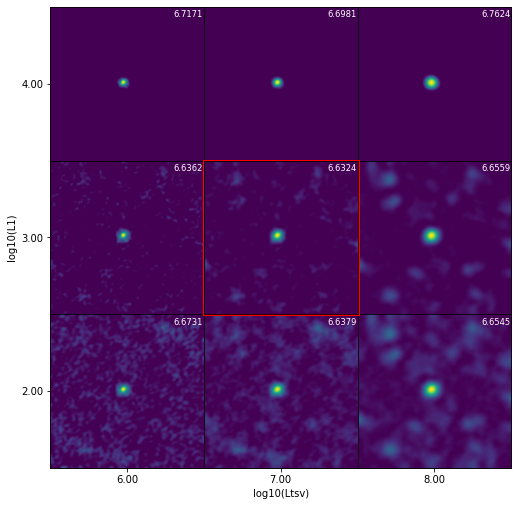

5min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e2, 1e3, 1e4]
Ltsv_list = [1e6, 1e7, 1e8]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='mycvresult', imagepolicy='full',
                       summarize=True, figfile='cvresult.png',
                       datafile='cvresult.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False)

## Accelerating cross-validation with Bayesian optimization

The `crossvalidation` method has an option to choose optimizer. Default optimizer is `'classical'` which evaluates each pair of `L1` and `Ltsv` in order to find the most reliable combination. In general, `'classical'` optimizer takes time because all combinations of given sets of `L1` and `Ltsv` must be evaluated. This makes practically difficult to seach wide range of `L1` and `Ltsv`. To address this issue, we've introduced another optimizer, `'bayesian'`. The `'bayesian'` optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12x12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the `'classical'` optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 

{'L1': 1000.0, 'Ltsv': 10000000.0}

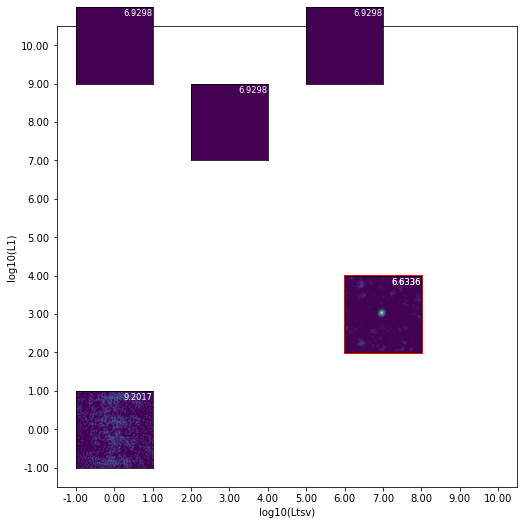

2min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
Ltsv_list =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='mycvresult2', imagepolicy='full',
                       summarize=True, figfile='cvresult2.png',
                       datafile='cvresult2.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False,
                      optimizer='bayesian', bayesopt_maxiter=15)